# Spatial analysis of clicked links :

We want to analyze wether there is a tendancy in the positions where the links are clicked and see if we have a significant difference with the position of the optimal link to click. <br/>
In order to do that, we use the python library BeautifulSoup that permits to find tags in a html file. <br/>

## Wikipedia page structure : 

We have a 2007 version of wikipedia, therefore the structure of the pages is quite simpler than the one we have now. We divide the structure in 2 : the body (red) and the infobox (green) and we will analyze where are located the links and then where are located the links clicked.


<img src="img/wiki_page_structure.png" alt="Wikipedia page structure" style="height: 600px; width: 1050px;"/>

In [1]:
#importing libairies

import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from tqdm import tqdm
from urllib.parse import unquote
import pickle as pkl

In [41]:
#defining useful functions

def verify(element): #verify that a tag <a> is effectively a hyperlink pointing towzrds antoher wikipedia page and not a picture
    if element is None:
        return True
    if element.get('href') is None:
        return True
    if element.get('href')[-7:-4] == 'jpg' or element.get('href')[-7:-4] == 'png':
        return True
    return False

def links_name(link): #Obtaining the name of the page toward which a link is pointing 
    link_name = ''
    if link.text != '':
        if link.get('title') != None:
            link_name = link.get('title')
        else: 
            link_name = link.text
    return link_name

def search_link(path_link, article_links): #Search the index of a link in the list of all links of an article
    index = article_links.index(path_link)    
    return index

def link_clicked(path_dataframe, links_dataframe): #obtain the list of the indexes of clicked linked in articles, with a dataframe of paths and a dataframe of pages in arguments
    relative_link_numbers = []
    for links in tqdm(path_dataframe['path']):
        if len(links) < 2:
            continue
        names = []
        links = links.split(";")
        links_def = [x.replace('_', ' ') for x in links]
        if '<' in links_def:
            continue #for now on we ignore path with backtracks
        for i in range(len(links_def)-1):   
            names = list(links_dataframe.loc[links_dataframe['pagename'] == links_def[i].replace(' ', '_'), 'link'])
            try:
                index = search_link(unquote(links_def[i+1]), names[0])
            except ValueError:
                continue #check this later
            link_number_in_page = links_dataframe.loc[links_dataframe['pagename'] == links_def[i].replace(' ', '_') , 'number'].values[0]
            relative_link_numbers.append(index/link_number_in_page)
    return relative_link_numbers


## Obtaining the list of every links in each article

We want to have a dataframe containing all the pages with the corresponding index of the link (and later the coordinates of every link)

In [38]:
directory = r'..\data\wikispeedia_articles_html\wpcd\wp'
link_DF = pd.DataFrame(columns = ['pagename', 'link', 'number'])

for filename in tqdm(os.listdir(directory)): #iteration over all the pages in order to obtain the list of all the links in each articles
    f = os.path.join(directory, filename)
    for filename_2 in os.listdir(f):
        g = os.path.join(f, filename_2)

        pagename = g.split("\\")[6]
        
        if pagename.split('.')[1] == 'jpg':
            continue
        pagename = pagename[:-4]
        
        with open(g, 'rb') as fp:
            soup = BeautifulSoup(fp, 'lxml', from_encoding="utf-8")

        count = 0
        counts = []
        pagenames = []
        link_name = []
        for link in soup.find_all('a'):  
            if verify(link):
                continue 

            if link.text != '':
                if link.get('title') != None:
                    link_name.append(link.get('title'))
                else: 
                    link_name.append(link.text)
            counts.append(count)
            pagenames.append(pagename)
            count+=1
        df_list = pd.DataFrame([[pagename, link_name, count]], columns = ['pagename', 'link', 'number'])
        link_DF = pd.concat([link_DF, df_list], ignore_index=True)
        
link_DF
      

100%|██████████| 38/38 [03:48<00:00,  6.02s/it]


,pagename,link,number
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[2007 Schools Wikipedia Selection, British His...",17
1,%C3%85land,"[2007 Schools Wikipedia Selection, Countries, ...",34
2,%C3%89douard_Manet,"[2007 Schools Wikipedia Selection, Artists, Cl...",32
3,%C3%89ire,"[2007 Schools Wikipedia Selection, Countries, ...",17
4,%C3%93engus_I_of_the_Picts,"[2007 Schools Wikipedia Selection, British His...",17
...,...,...,...
5863,Zirconium,"[2007 Schools Wikipedia Selection, Chemical el...",62
5864,Zoroaster,"[2007 Schools Wikipedia Selection, Religious f...",36
5865,Zuid-Gelders,"[2007 Schools Wikipedia Selection, European Ge...",11
5866,Zulu,"[2007 Schools Wikipedia Selection, African Geo...",24


In [39]:
link_DF.to_pickle(r"..\data\links_in_article.pkl") #Pickle of the dataframe containing wikipedia pages' links

In [9]:
directory1 = r"..\data\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_finished.tsv"
directory2 = r"..\data\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_unfinished.tsv"
with open(directory1) as fp1, open(directory2) as fp2:
    path_finished = pd.read_csv(fp1, sep = '\t', encoding="iso-8859-1")
    path_unfinished = pd.read_csv(fp2, sep = '\t', encoding="iso-8859-1")

path_finished #dataframe of the paths

,userID,timestamp,duration,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


## Links indexes in the page : 

Then with the dataframe of finished and unfinished paths, we obtain the indexes of the clicked links in the pages

In [45]:
#Finished paths link clicked  number

file_linkDF = r"..\data\links_in_article.pkl"
with open(file_linkDF, 'rb') as fp1:
    link_DF = pd.read_pickle(fp1)
'''
file_pathf = r"..\data\link_number_f.pkl"
file_pathu = r"..\data\link_numbers_u.pkl"

 as fp1, open(file_pathf, 'rb') as fp2, open(file_pathu, 'rb') as fp3:
    link_DF = pd.read_pickle(fp1)
    link_numbers_f = pd.read_pickle(fp2)
    link_numbers_u = pd.read_pickle(fp3)
    '''
link_DF['number'] = link_DF.number.astype(int)



link_numbers_f = link_clicked(path_finished, link_DF)
link_numbers_u = link_clicked(path_unfinished, link_DF)

pagename    object
link        object
number       int32
dtype: object


100%|██████████| 24875/24875 [02:09<00:00, 191.93it/s]


In [49]:
#pickling to not have to run the above cell

pd.Series(link_numbers_f).to_pickle(r"..\data\link_number_f.pkl")
pd.Series(link_numbers_u).to_pickle(r"..\data\link_numbers_u.pkl")

In [78]:
link_DF['number'].describe()

count    5868.000000
mean       38.858214
std        60.232986
min         0.000000
25%        16.000000
50%        26.000000
75%        45.000000
max      1424.000000
Name: number, dtype: float64

## Indexes of clicked links : 

With what we've done before we can make a histogram of the frequency of relative indexes. By relative indexes we mean the index of the clicked link divided by the total number of links in the page so that we can eliminate the disparity of the number of links in different articles (standard deviation of 60)

We can clearly see that the first links are more clicked on and that the click frequency decrease along the article

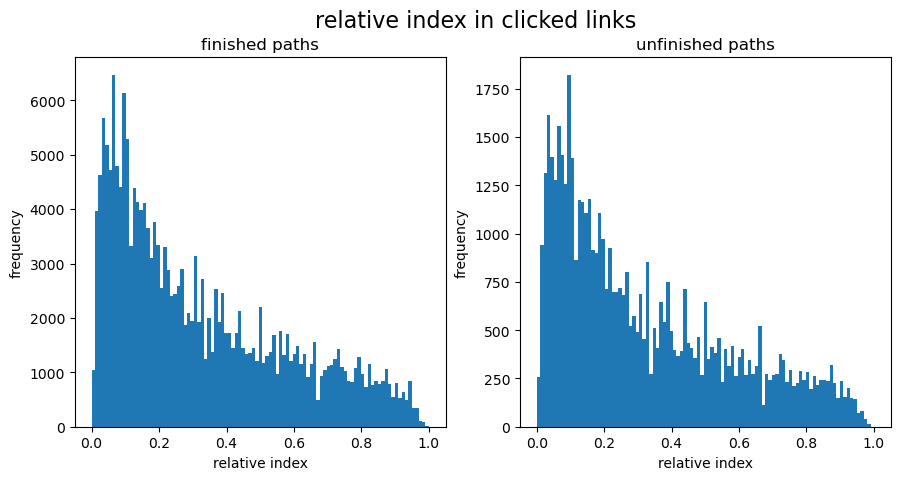

In [77]:


fig, ax = plt.subplots(nrows = 1, ncols = 2)

fig.suptitle('relative index of clicked links', ha = 'left', fontsize = 16)
plt.subplots_adjust(right = 1.4)

ax[0].hist(link_numbers_f, bins = np.linspace(0,1,100))
ax[0].set_title('finished paths')
ax[0].set_ylabel('frequency')
ax[0].set_xlabel('relative index')

ax[1].hist(link_numbers_u, bins = np.linspace(0,1,100))
ax[1].set_title('unfinished paths')
ax[1].set_ylabel('frequency')
ax[1].set_xlabel('relative index')
plt.show()